# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from main import stochastic_training
from Environment import *
plt.rcParams.update({'font.size': 15})
import pyarrow.feather as feather

In [2]:
training_platform = TrainingPlatform.Notebook
agent_num=1
action_num=2
signal_size =1
learning_rate_theta = 1e-4 / signal_size
learning_rate_wv = 1e-4 / signal_size
memory_size = 16
batch_size = 16
training_episodes = int(4e6)
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
algorithm = Algorithm.REGULAR
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
# prior_red_list = logit([2/3, 1/2, 1/3])
prior_red_list = None
preferred_colour_pr_list = [0.5, 0.5]
score_func = ScoreFunction.LOG
decision_rule = DecisionRule.STOCHASTIC
agent_list = []
evaluation_step = 10
weights_init = WeightsInit.RANDOM
report_order = ReportOrder.FIXED
signal_size_list = np.ones(shape=agent_num, dtype=int) * signal_size

metric_dict = stochastic_training(
                             training_platform, agent_list, learning_rate_theta, learning_rate_wv,
                             memory_size, batch_size, training_episodes,
                             decay_rate, beta1, beta2, algorithm, learning_std,
                             fixed_std, pr_red_ball_red_bucket, pr_red_ball_blue_bucket,
                             prior_red_list, agent_num, action_num, score_func, decision_rule, 
                             preferred_colour_pr_list, evaluation_step, weights_init, report_order, signal_size_list)

agent0
learning_rate_theta= 0.0001  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 0.3
Updating weights with Regular algorithm.


  0%|          | 0/4000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
import os

sequence_number = 1
parent_folder_name = 'Temp' # 'Deterministic' or 'Stochastic'

dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list',
                                    preferred_colour_pr_list, score_func.name,
                                    decision_rule.name, weights_init.name, report_order.name, sequence_number)

dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)

while os.path.exists(dir_path):
    sequence_number += 1
    dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list',
                                    preferred_colour_pr_list, score_func.name,
                                    decision_rule.name, weights_init.name, report_order.name, sequence_number)
    dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)
    


os.makedirs(dir_path)

In [26]:
backwards_index = -int(1e6)
print(np.mean(metric_dict['prior_outcome'][backwards_index:]))
print(np.mean(metric_dict['dm_outcome'][backwards_index:]))
print(np.mean(metric_dict['bayesian_outcome'][backwards_index:]))

0.5421575
0.5006375
0.5853375


In [27]:
# loss_df = pd.DataFrame(loss_list,columns=['loss'])
# fig, axs = plt.subplots(2, figsize=(18, 18))
# gradients_box_plot(df=loss_df,bins=10, col_name='loss',color='red',ax=axs[0])
# gradients_box_plot(df=loss_df.iloc[backwards_index:,:], bins=10, col_name='loss', color='blue', ax=axs[1])
# plt.savefig(dir_path + 'loss_boxplot.png')

In [28]:
from scipy.ndimage import uniform_filter1d

print(np.mean(metric_dict['loss'][backwards_index:]))
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(metric_dict['loss'],'.',markersize=0.1, label='loss')
average_loss = uniform_filter1d(metric_dict['loss'],size=100)
ax.plot(average_loss,'.', markersize=0.1, label='running window average')
lgnd = ax.legend(loc='upper right',markerscale=100)
xticks = ax.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xlabels[1:-1])
ax.set_xlabel('Millon Steps')
fig.suptitle('Root Mean Squared Log Loss')
plt.savefig(dir_path + 'loss_dotsplot.png')

In [30]:
metric_df = pd.DataFrame(metric_dict)
with open(dir_path + r'metric', 'wb') as f:
    feather.write_feather(metric_df, f)

In [31]:
check_point_index = int(1e6)
metric_df.head(check_point_index)['loss'].describe().to_csv(dir_path + 'head_loss_describe_table.csv')
print(metric_df.head(check_point_index)['loss'].describe())
metric_df.tail(check_point_index)['loss'].describe().to_csv(dir_path + 'tail_loss_describe_table.csv')
print(metric_df.tail(check_point_index)['loss'].describe())

count    400000.000000
mean          0.015886
std           0.028178
min           0.000012
25%           0.004930
50%           0.008019
75%           0.012642
max           0.448140
Name: loss, dtype: float64
count    400000.000000
mean          0.015886
std           0.028178
min           0.000012
25%           0.004930
50%           0.008019
75%           0.012642
max           0.448140
Name: loss, dtype: float64


In [32]:
rolling_window_size = 10000
rolling_df = metric_df.loc[:, ['loss', 'dm_outcome', 'bayesian_outcome', 'dr_outcome']].rolling(rolling_window_size, center=True).mean()

fig,ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax1.plot(rolling_df['loss'], label='Loss')
ax2.plot(rolling_df['dm_outcome'],'g', label='Decision Markets outcome')
ax2.plot(rolling_df['bayesian_outcome'], 'r', label='Bayesian outcome')
# ax2.plot(rolling_df['dr_outcome'], 'b.',markersize=0.01)
ax2.set_ylim([0.5,0.75])
ax1.legend(loc='lower left', bbox_to_anchor=(0,1))
ax2.legend(loc='lower right', bbox_to_anchor=(1,1))
xticks = ax1.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax1.set_xticks(xticks[1:-1])
ax1.set_xticklabels(xlabels[1:-1])
ax1.set_xlabel('Millon Steps')
fig.suptitle('Rolling Window Metrics with Window Size ' + str(rolling_window_size), y=1.3)
plt.savefig(dir_path + 'loss_reward_plot.png')

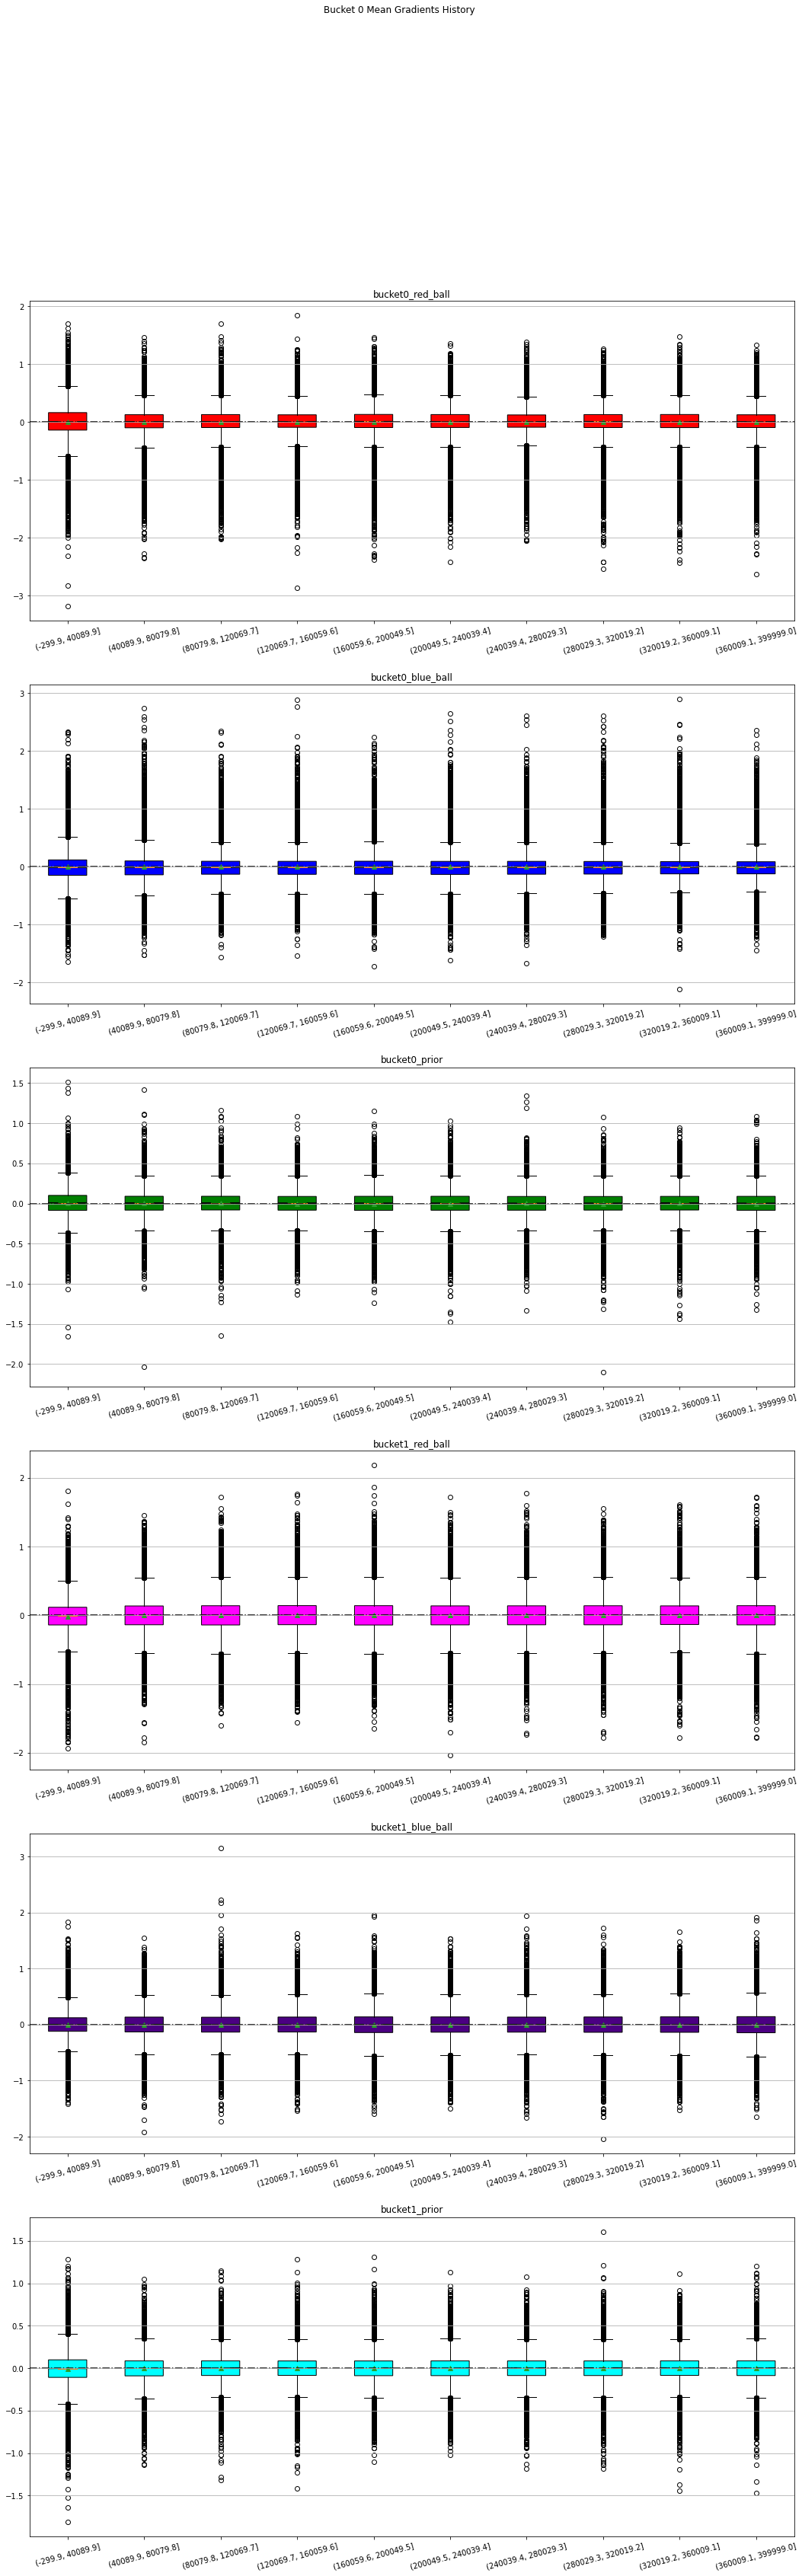

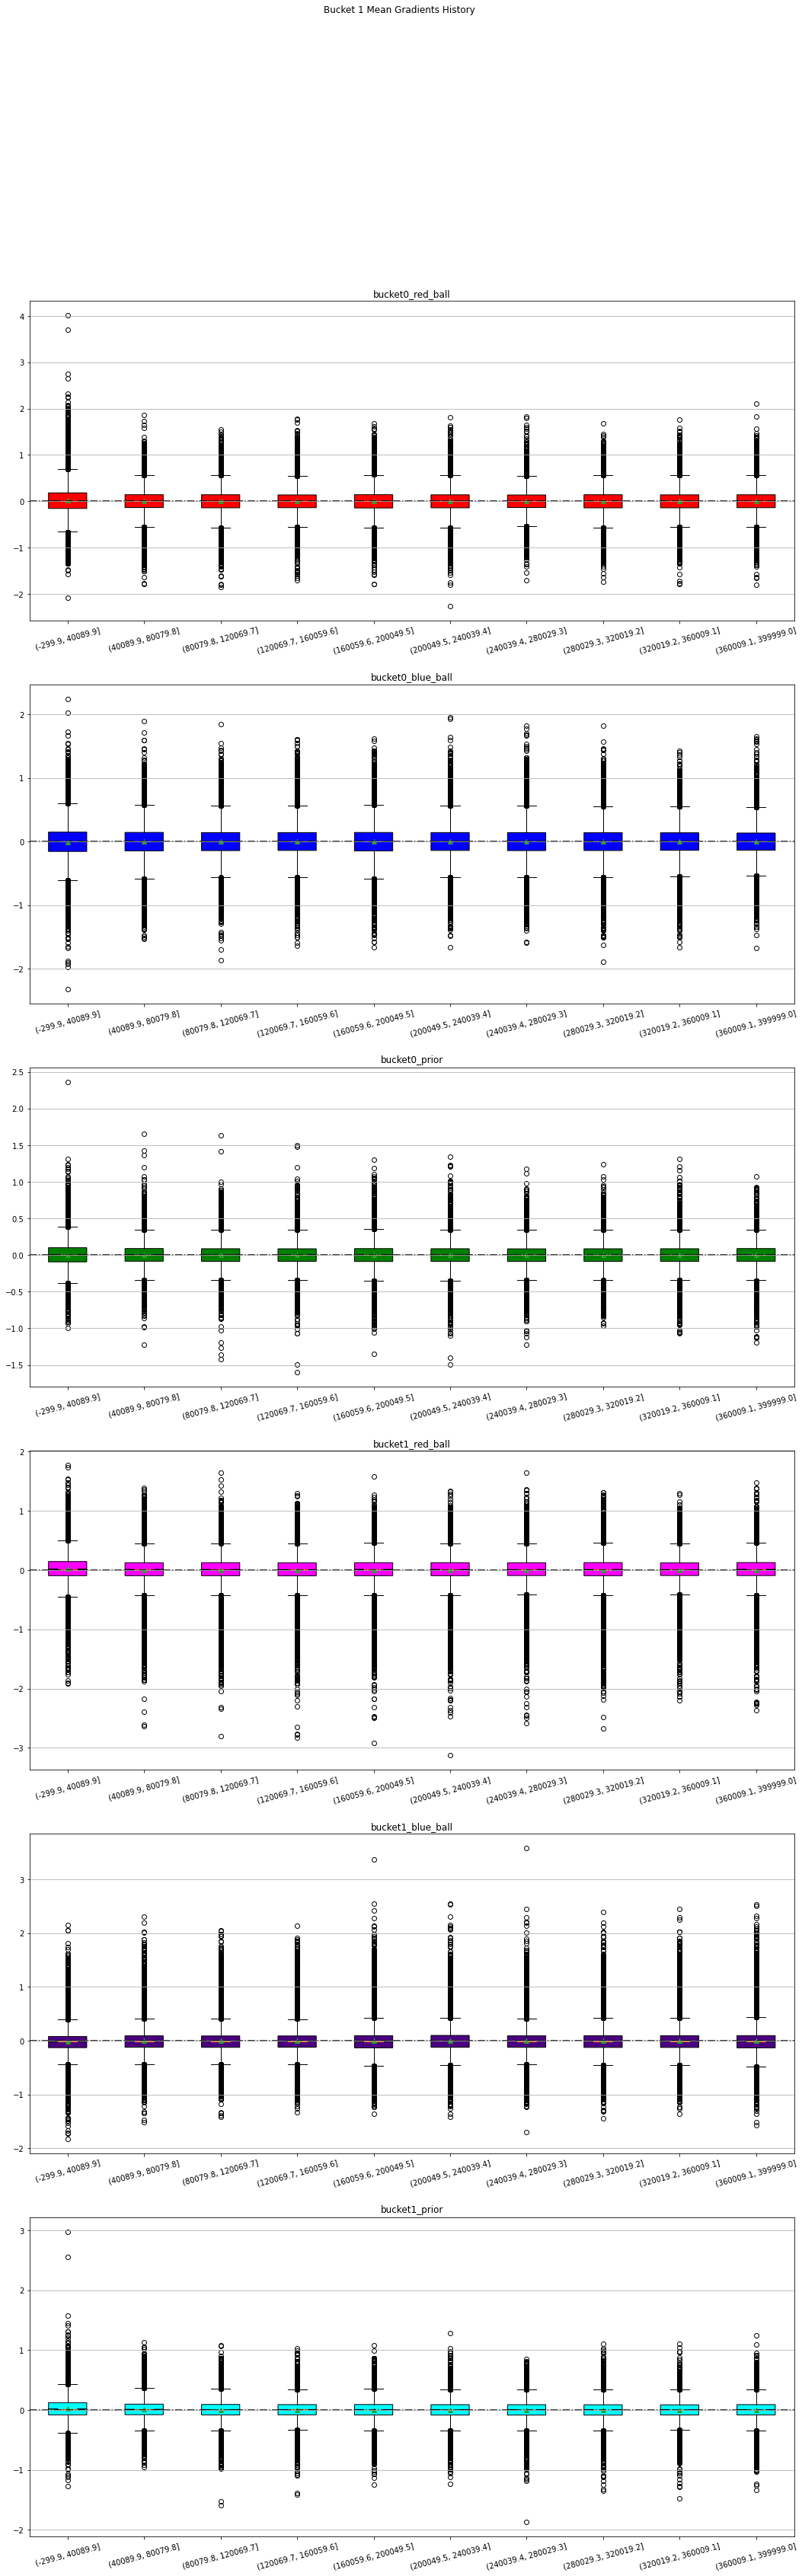

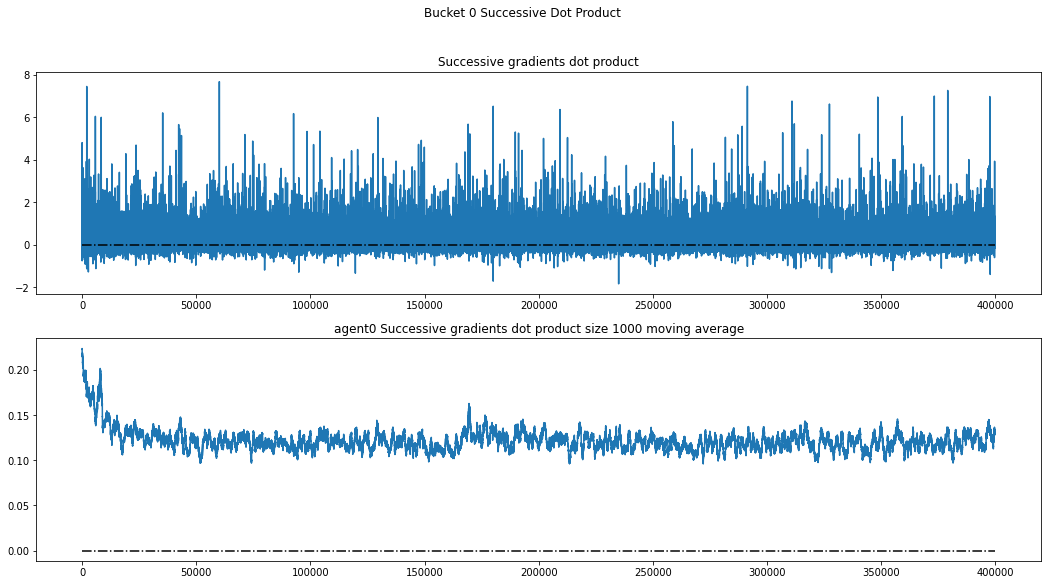

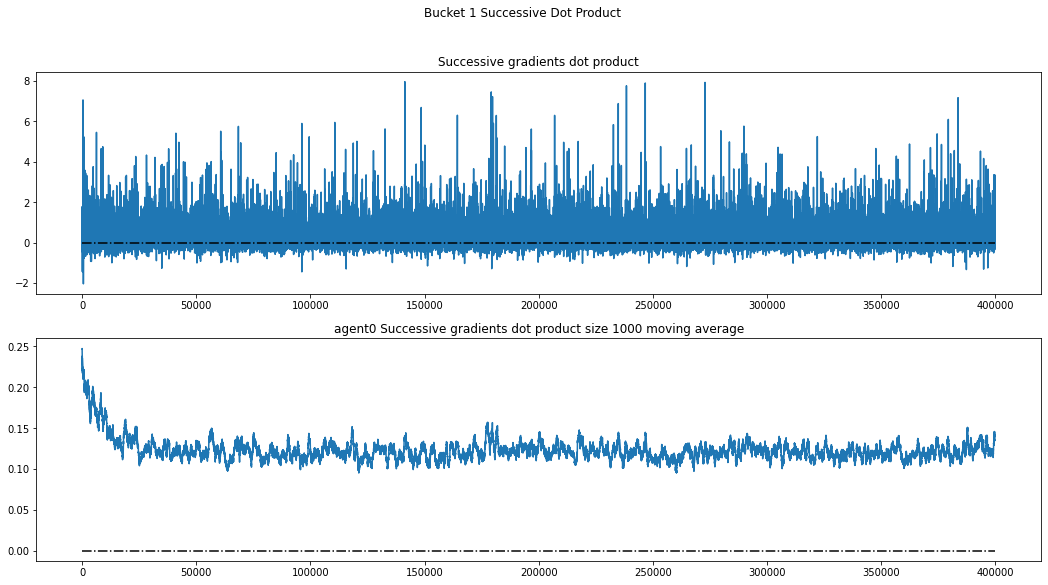

In [34]:
for agent in agent_list:
#     agent.reward_history_plot(top_margin=0.15, bottom_margin=0.15)
#     agent.report_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
#     agent.mean_weights_history_plot()
#     agent.std_gradients_history_plot()
#     agent.std_history_plot()

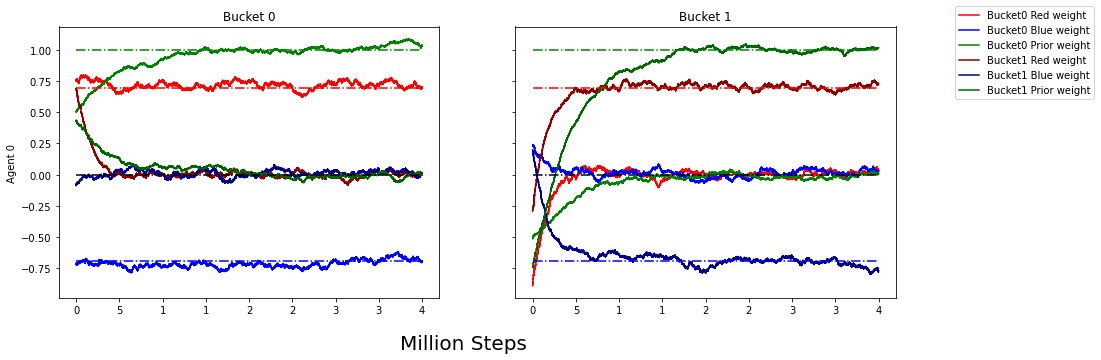

In [35]:
feature_num = 3

fig, axs=plt.subplots(agent_num, action_num, figsize=(15, 5 * agent_num), sharex=True, sharey=True, squeeze=False)


for agent, ag_no in zip(agent_list, range(agent_num)):
    mean_weights_df_list = agent.mean_weights_history_df() 
    reward_df = agent.reward_history_dataframe()
    with open(dir_path + f'{agent.name}_score', 'wb') as f:
        feather.write_feather(reward_df, f)
    # Save the weights
    for no in range(2):
        with open(dir_path + f'{agent.name}_bucket{no}_weights', 'wb') as f:
            feather.write_feather(mean_weights_df_list[no], f)
    
    for df, ac_no in zip(mean_weights_df_list, range(2)):

        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 0],
                               label='Bucket0 Red weight', color='red')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 1],
                               label='Bucket0 Blue weight', color='blue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 2],
                               label='Bucket0 Prior weight', color='green')

        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 0],
                               label='Bucket1 Red weight', color='darkred')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 1],
                               label='Bucket1 Blue weight', color='darkblue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 2],
                               label='Bucket1 Prior weight', color='darkgreen')
                
for r_no in range(agent_num):
    axs[r_no, 0].set_ylabel(f'Agent {r_no}')
    for c_no in range(action_num):
        if r_no == 0:
            axs[r_no, c_no].set_title(f'Bucket {c_no}')
        axs[r_no, c_no].hlines(y=np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket), xmin=0,

                            xmax=len(df), colors='red',
                                     linestyles='dashdot')
        axs[r_no, c_no].hlines(
                y=np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)), xmin=0,
                xmax=len(df), colors='blue',
                linestyles='dashdot')
        axs[r_no, c_no].hlines(y=1, xmin=0, xmax=len(df), colors='green', linestyles='dashdot')
        axs[r_no, c_no].hlines(y=0, xmin=0, xmax=len(df), colors='black', linestyles='dashdot')

xticks = axs[-1, 0].get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
axs[-1,0].set_xticks(xticks[1:-1])
axs[-1,0].set_xticklabels(xlabels[1:-1])


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.95, 0.95), ncol=1)
fig.text(0.5, 0.0, 'Million Steps', ha='center', va='center', fontsize=20)
# fig.text(0.75, 1, 'Bucket 1', ha='center', va='center', fontsize=20)


plt.savefig(dir_path + 'mean_weights.png', bbox_inches='tight')


In [36]:
def signal_encode(ball_colour, bucket_no, prior_pair):
    ball_col_val_map = {'red': 0, 'blue': 1}
    signal_mat = np.zeros((1, 6))
    signal_mat[0, [2, 5]] = np.squeeze(prior_pair)
    signal_mat[0, bucket_no * 3 + ball_col_val_map[ball_colour]] += 1

    return signal_mat

Text(0.5, 1.0, 'Signal from Bucket 1')

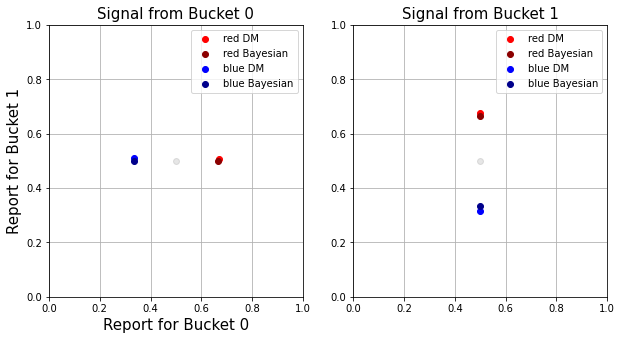

In [37]:
def context_weights_report(context_array, weights_mat):
    return np.matmul(context_array.reshape(1, 6), weights_mat)


init_logit_prior = (0, 0)

nrow = agent_num
ncol = action_num
fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow), squeeze=False)

for ball_col in ['red', 'blue']:
    for bucket_i in range(action_num):
        for ag_i in range(agent_num):
            
            # Generate a numpy mat average weight for each agent
            mean_weights_df_list = agent_list[ag_i].mean_weights_history_df() 
            bu0_weights = mean_weights_df_list[0].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            bu1_weights = mean_weights_df_list[1].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            weight_mat = np.concatenate((bu0_weights, bu1_weights), axis=1)
            
            reports = np.empty((0, 2), float)

            if ag_i == 0:
                prev_reports = np.zeros(2)
                prev_ba_reports = np.zeros(2)

            signal_array = signal_encode(ball_col, bucket_i, prev_reports)
            reports = context_weights_report(signal_array, weight_mat)
            ba_signal_array = signal_encode(ball_col, bucket_i, prev_ba_reports)
            ba_reports = BayesianUpdateMat(signal_array, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
            
            axs[ag_i, bucket_i].scatter(expit(reports[0, 0]), expit(reports[0, 1]), marker='o', color=ball_col, label=f'{ball_col} DM')
            axs[ag_i, bucket_i].scatter(expit(ba_reports[0]), expit(ba_reports[1]), marker='o', color=f'dark{ball_col}', label=f'{ball_col} Bayesian')
            axs[ag_i, bucket_i].set_ylim(0.0, 1)
            axs[ag_i, bucket_i].set_xlim(0.0, 1)
            axs[ag_i, bucket_i].grid(True)
            if ag_i == 0:
                axs[ag_i, bucket_i].scatter(0.5, 0.5, marker='o', color='grey', alpha=0.1)
            else:
                axs[ag_i, bucket_i].scatter(expit(prev_reports[0, 0]), expit(prev_reports[0, 1]), marker='o', color=ball_col, alpha=0.1)
            
            axs[-1, 0].set_xlabel('Report for Bucket 0', fontsize=15)
            axs[-1, 0].set_ylabel('Report for Bucket 1', fontsize=15)
            
            prev_reports = reports.copy()
            prev_ba_reports = ba_reports.copy()
            
axs[0, 0].legend(loc='upper left', ncol=2, fontsize=10)            
axs[0, 0].set_title('Signal from Bucket 0', fontsize=15)
axs[0, 1].set_title('Signal from Bucket 1', fontsize=15)

plt.savefig(dir_path + 'reports.png', bbox_inches='tight')

In [38]:
# feature_num=3
# for agent in agent_list:
#     mean_weights_df_list = agent.mean_weights_history_df() 
#     for df, title_no in zip(mean_weights_df_list, range(action_num)):
#     #     df = _df.rolling(100).mean()
#         last_third_idx = len(df) // 3
#         fig, ax = plt.subplots(figsize=(18, 9))

#         for bucket_no in range(action_num):
#             ax.plot(df.iloc[1:, bucket_no * feature_num + 0],
#                                    label='Bucket ' + str(bucket_no) + ' Red weight')
#             ax.plot(df.iloc[1:, bucket_no * feature_num + 1],
#                                    label='Bucket ' + str(bucket_no) + ' Blue weight')
#             ax.plot(df.iloc[1:, bucket_no * feature_num + 2],
#                                    label='Bucket ' + str(bucket_no) + ' Prior weight')

#         ax.hlines(y=np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket), xmin=0,

#                         xmax=len(df), colors='red',
#                                  linestyles='dashdot')
#         ax.annotate('%.3f' % np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket),
#                                    xy=(len(df) / 2,
#                                        np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket)),
#                                    xytext=(len(df) / 2, np.log(2) / 2), arrowprops=dict(arrowstyle="->"))
#         if bucket_no == title_no:
#             ax.annotate('std:%.3f' % df.iloc[last_third_idx:, 0].std(),
#                                    xy=(len(df) * 0.8,
#                                        np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket)),
#                                    xytext=(len(df) * 0.8, np.log(2) / 2), arrowprops=dict(arrowstyle="->"))
#         ax.hlines(
#             y=np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)), xmin=0,
#             xmax=len(df), colors='blue',
#             linestyles='dashdot')
#         ax.annotate(
#             '%.3f' % np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)),
#             xy=(len(df) / 2, np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket))),
#             xytext=(len(df) / 2, np.log(1 / 2) / 2), arrowprops=dict(arrowstyle="->"))
#         if bucket_no == title_no:
#             ax.annotate(
#             'std:%.3f' % df.iloc[last_third_idx:, 1].std(),
#             xy=(len(df) * 0.8, np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket))),
#             xytext=(len(df) * 0.8, np.log(1 / 2) / 2), arrowprops=dict(arrowstyle="->"))
#         ax.hlines(y=1, xmin=0, xmax=len(df), colors='green', linestyles='dashdot')
#         ax.hlines(y=0, xmin=0, xmax=len(df), colors='black', linestyles='dashdot')
#         ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=action_num)
#         ax.set_title('Bucket ' + str(title_no) + ' Mean Weights History', y=1.3)
#         plt.savefig(dir_path + agent.name + '_bucket' + str(title_no) + '_mean_weights.png', bbox_inches='tight')

In [ ]:
import math
from scipy import stats
from scipy.special import logit, expit
from Environment import expected_log_reward_red_ball, analytical_best_report_ru_rs

In [ ]:
mu = 0
sigma = 0.2
prior_red = 0.5
colours = ['red', 'blue', 'yellow', 'green', 'purple']
variance = np.square(sigma)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
z = np.linspace(mu-2*sigma, mu+2*sigma, 5)
fig, axs = plt.subplots(5, figsize=(14, 4*5))
axs[0].plot(x, stats.norm.pdf(x, mu, sigma))
axs[0].vlines(z, ymin=0, ymax=np.max(stats.norm.pdf(x=x, loc=mu, scale=sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(z, zip(z, [0]*5)):
    axs[0].annotate('%.3f'%value, xy=coord)
axs[1].plot(expit(x), stats.norm.pdf(x, mu, sigma))
axs[1].vlines(expit(z), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z), zip(expit(z), [0]*5)):
    axs[1].annotate('%.3f'%value, xy=coord)
axs[2].plot(np.log(expit(x))-np.log(1/2), stats.norm.pdf(x, mu, sigma))
# axs[2].plot(np.log(1/2) - np.log(expit(x)), stats.norm.pdf(x, mu, sigma))
axs[2].vlines(np.log(expit(z))-np.log(1/2), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(np.log(expit(z))-np.log(1/2), zip(np.log(expit(z))-np.log(1/2), [0]*5)):
    axs[2].annotate('%.3f'%value, xy=coord)
axs[3].plot(expit(x) - (np.square(expit(x)) + np.square(1 - expit(x)))/2 - 0.25, stats.norm.pdf(x, mu, sigma))
axs[3].vlines(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, [0]*5)):
    axs[3].annotate('%.3f'%value, xy=coord)
actual_pr_ru_rs = analytical_best_report_ru_rs(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
expected_init = expected_log_reward_red_ball(actual_pr_ru_rs, 1/2, prior_red)
expected_z = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(z)), prior_red)
expected_x = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(x)), prior_red)
# axs[4].plot(expected_x-expected_init, stats.norm.pdf(x, mu, sigma))
# axs[4].vlines(expected_z-expected_init, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
# for value, coord in zip(expected_z-expected_init, zip(expected_z-expected_init, [0]*5)):
#     axs[4].annotate('%.3f'%value, xy=coord)
axs[4].plot(x, expected_x-expected_init)
axs[4].vlines(z, ymin=np.min(expected_x-expected_init), ymax=np.max(expected_x-expected_init), linestyle='dashdot', colors=colours)
for value, coord in zip(z, zip(z, [np.min(expected_x-expected_init)]*5)):
    axs[4].annotate('%.3f'%value, xy=coord)
plt.show()

In [ ]:
from Environment import expected_log_reward_red_ball, expected_log_reward_blue_ball, analytical_best_report_ru_rs, analytical_best_report_ru_bs

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_bs_ru = 1/3
pr_bs_bu = 2/3

In [ ]:
r1 = np.linspace(start=0.01, stop=0.99, num=50)
r2 = np.linspace(start=0.01, stop=0.99, num=50)
r1v, r2v = np.meshgrid(r1, r2)
actual_pr_ru_bs1 = analytical_best_report_ru_bs(pr_ru=pr_ru1, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
actual_pr_ru_bs2 = analytical_best_report_ru_bs(pr_ru=pr_ru2, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
actual_pr_ru_bsv = actual_pr_ru_bs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)

In [ ]:
rv

In [ ]:
actual_pr_ru_bsv

In [ ]:
def dm_expected_log_reward_blue_ball(pr_ru1, pr_ru2, pr_bs_ru, pr_bs_bu):
    r1 = np.linspace(start=0.01, stop=0.99, num=50)
    r2 = np.linspace(start=0.01, stop=0.99, num=50)
    r1v, r2v = np.meshgrid(r1, r2)
    actual_pr_ru_bs1 = analytical_best_report_ru_bs(pr_ru=pr_ru1, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
    actual_pr_ru_bs2 = analytical_best_report_ru_bs(pr_ru=pr_ru2, pr_bs_ru=pr_bs_ru, pr_bs_bu=pr_bs_bu)
    rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
    actual_pr_ru_bsv = actual_pr_ru_bs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    return r1v, r2v, expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_bsv, estimated_pr_ru_bs=rv, pr_ru=pr_ruv)

In [ ]:
r1v, r2v, z = dm_expected_log_reward_blue_ball( pr_ru1, pr_ru2, pr_bs_ru, pr_bs_bu)

In [ ]:
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(r1v, r2v, z, 100, cmap='binary')
ax.plot_surface(r1v, r2v, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('r1')
ax.set_ylabel('r2')
ax.set_zlabel('expectation')
ax.view_init(90, 60)

plt.show()

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_rs_ru = 2/3
pr_rs_bu = 1/3

In [ ]:
def dm_expected_log_reward_red_ball(pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu):
    r1 = np.linspace(start=0.01, stop=0.99, num=50)
    r2 = np.linspace(start=0.01, stop=0.99, num=50)
    r1v, r2v = np.meshgrid(r1, r2)    
    actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
    actual_pr_ru_rs2 = analytical_best_report_ru_rs(pr_ru=pr_ru2, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)   
    rv = r1v * (r1v > r2v) + r2v * (r1v <= r2v)
    actual_pr_ru_rsv = actual_pr_ru_rs1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    pr_ruv = pr_ru1 * (r1v > r2v) + pr_ru2 * (r1v <= r2v)
    return r1v, r2v, expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_rsv, estimated_pr_ru_rs=rv, pr_ru=pr_ruv)

r1v, r2v, z = dm_expected_log_reward_red_ball(pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(r1v, r2v, z, 100, cmap='binary')
ax.plot_surface(r1v, r2v, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('r1')
ax.set_ylabel('r2')
ax.set_zlabel('expectation')
ax.view_init(90, 60)

plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Surface(z=z, x=r1v, y=r2v)])
fig.update_layout(title='Mt Bruno Elevation', autosize=True,
#                   width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
pr_ru1 = 1/4
pr_ru2 = 3/4
pr_rs_ru = 2/3
pr_rs_bu = 1/3

In [ ]:
from numpy.random import Generator, PCG64
def stochastic_decision_rule(r1v, r2v, probabilities, pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu):
#     generator = Generator(PCG64())
    result_array = np.zeros(r1v.shape)
    r_stack_v = np.dstack((r1v, r2v))
    for i in range(r_stack_v.shape[0]):
        for j in range(r_stack_v.shape[1]):
            r1, r2 = r_stack_v[i][j]
            if r1 > r2:
                pr = probabilities
            else:
                pr = probabilities[::-1]
            actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
            actual_pr_ru_rs2 = analytical_best_report_ru_rs(pr_ru=pr_ru2, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu) 
            result_array[i][j] = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_rs1, estimated_pr_ru_rs=r1, pr_ru=pr_ru1)/pr[0] + expected_log_reward_red_ball(actual_pr_ru_rs=pr_ru2, estimated_pr_ru_rs=r2, pr_ru=pr_ru2)/pr[1]
            
    return result_array

In [ ]:
z = stochastic_decision_rule(r1v, r2v, [0.8, 0.2], pr_ru1, pr_ru2, pr_rs_ru, pr_rs_bu)

In [ ]:
actual_pr_ru_rs1 = analytical_best_report_ru_rs(pr_ru=pr_ru1, pr_rs_ru=pr_rs_ru, pr_rs_bu=pr_rs_bu)
actual_pr_ru_rs1

In [ ]:
fig = go.Figure(data=[go.Surface(z=z, x=r1v, y=r2v)])
fig.update_layout(title='Mt Bruno Elevation', autosize=True,
#                   width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()